<a href="https://colab.research.google.com/github/HSandison/BarkBeetleDetection/blob/main/bark_beetle_detection_initial_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install PyTorch for GPU
!pip install torch torchvision torchaudio

# Install Detectron2
!pip install -U torch torchvision
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install OpenCV and pycocotools for handling images and COCO format
!pip install opencv-python-headless
!pip install pycocotools


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-t0mwooxm
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-t0mwooxm
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done


# New Section

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import libraries
import os
import json
import random
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

import torch
from detectron2 import model_zoo
from detectron2.utils.logger import setup_logger
setup_logger()


<Logger detectron2 (DEBUG)>

In [ ]:
# Define paths and load COCO Annotations
# Define the path to your images and annotations
dataset_dir = "/content/drive/MyDrive/BarkBeetle/bark_beetle_detection/"
images_dir = os.path.join(dataset_dir, 'images')
annotations_file = os.path.join(dataset_dir, 'annotations', 'coco_annotations_square_dish_camera_help_by_hand.json')

# Load the COCO annotations
with open(annotations_file, 'r') as f:
    annotations = json.load(f)

# Display the total number of annotations
print("Total annotations:", len(annotations['annotations']))


Total annotations: 604


In [ ]:
# Create directories for train, val, and test within the dataset directory
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


In [ ]:
# Set seed for reproducibility
random.seed(42)

# Split the data
image_filenames = os.listdir(images_dir)
random.shuffle(image_filenames)

# Define split sizes
train_size = int(0.7 * len(image_filenames))  # 70% for training
val_size = int(0.15 * len(image_filenames))  # 15% for validation
test_size = len(image_filenames) - train_size - val_size  # Remaining 15% for testing

# Split filenames
train_filenames = image_filenames[:train_size]
val_filenames = image_filenames[train_size:train_size + val_size]
test_filenames = image_filenames[train_size + val_size:]

# Function to copy images to respective directories
def copy_images(filenames, source_dir, dest_dir):
    for filename in filenames:
        src = os.path.join(source_dir, filename)
        dst = os.path.join(dest_dir, filename)
        cv2.imwrite(dst, cv2.imread(src))

# Copy images to the respective directories
copy_images(train_filenames, images_dir, train_dir)
copy_images(val_filenames, images_dir, val_dir)
copy_images(test_filenames, images_dir, test_dir)

# Display the counts
print(f"Train images: {len(train_filenames)}, Val images: {len(val_filenames)}, Test images: {len(test_filenames)}")


Train images: 4, Val images: 1, Test images: 2


In [ ]:
def create_subset_annotations(filenames, annotations, subset_name):
    subset_annotations = {
        'images': [],
        'annotations': [],
        'categories': annotations['categories']
    }

    # Create a mapping for filename to image ID
    filename_to_id = {image['file_name']: image['id'] for image in annotations['images']}

    for filename in filenames:
        if filename in filename_to_id:
            image_id = filename_to_id[filename]
            # Add image info
            image_info = next(item for item in annotations['images'] if item['id'] == image_id)
            subset_annotations['images'].append(image_info)

            # Add corresponding annotations
            for ann in annotations['annotations']:
                if ann['image_id'] == image_id:
                    subset_annotations['annotations'].append(ann)

    return subset_annotations

# Create annotations for each subset
train_annotations = create_subset_annotations(train_filenames, annotations, "train")
val_annotations = create_subset_annotations(val_filenames, annotations, "val")
test_annotations = create_subset_annotations(test_filenames, annotations, "test")

# Save filtered annotations in the annotations directory
with open(os.path.join(dataset_dir, 'annotations', "coco_annotations_train.json"), 'w') as f:
    json.dump(train_annotations, f)
with open(os.path.join(dataset_dir, 'annotations', "coco_annotations_val.json"), 'w') as f:
    json.dump(val_annotations, f)
with open(os.path.join(dataset_dir, 'annotations', "coco_annotations_test.json"), 'w') as f:
    json.dump(test_annotations, f)

print("Annotations created and saved for train, validation, and test sets.")


Annotations created and saved for train, validation, and test sets.


In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

# Register the datasets
register_coco_instances("bark_beetle_train", {}, os.path.join(dataset_dir, 'annotations', "coco_annotations_train.json"), train_dir)
register_coco_instances("bark_beetle_val", {}, os.path.join(dataset_dir, 'annotations', "coco_annotations_val.json"), val_dir)
register_coco_instances("bark_beetle_test", {}, os.path.join(dataset_dir, 'annotations', "coco_annotations_test.json"), test_dir)

# Verify registration
train_metadata = MetadataCatalog.get("bark_beetle_train")
val_metadata = MetadataCatalog.get("bark_beetle_val")

print("Registered training dataset with", len(DatasetCatalog.get("bark_beetle_train")), "images.")
print("Registered validation dataset with", len(DatasetCatalog.get("bark_beetle_val")), "images.")


[10/04 08:17:31 d2.data.datasets.coco]: Loaded 4 images in COCO format from /content/drive/MyDrive/BarkBeetle/bark_beetle_detection/annotations/coco_annotations_train.json
Registered training dataset with 4 images.
[10/04 08:17:31 d2.data.datasets.coco]: Loaded 1 images in COCO format from /content/drive/MyDrive/BarkBeetle/bark_beetle_detection/annotations/coco_annotations_val.json
Registered validation dataset with 1 images.


In [ ]:
# Configure the model for training

from detectron2.config import get_cfg

# Initialize configuration
cfg = get_cfg()

# Load the Mask R-CNN model configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Set the dataset names
cfg.DATASETS.TRAIN = ("bark_beetle_train",)
cfg.DATASETS.TEST = ("bark_beetle_val",)  # Validation dataset

# Data loader settings
cfg.DATALOADER.NUM_WORKERS = 2  # Number of workers for data loading

# Solver settings
cfg.SOLVER.IMS_PER_BATCH = 2  # Batch size
cfg.SOLVER.BASE_LR = 0.00025  # Learning rate
cfg.SOLVER.MAX_ITER = 3000  # Number of iterations

# Output directory
cfg.MODEL.OUTPUT_DIR = "./output"  # Directory to save model outputs

# Checkpoint settings
cfg.SOLVER.CHECKPOINT_PERIOD = 500  # Save checkpoint every 500 iterations

# Set the number of classes in the model (including the background)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(train_metadata.get("thing_classes", []))

# Create output directory
os.makedirs(cfg.MODEL.OUTPUT_DIR, exist_ok=True)


In [ ]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")


GPU is available!
GPU Name: Tesla T4


In [ ]:
# Install PyTorch for GPU
!pip install torch torchvision torchaudio

# Install Detectron2
!pip install -U torch torchvision
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install OpenCV and pycocotools for handling images and COCO format
!pip install opencv-python-headless
!pip install pycocotools


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-5aatazaz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-5aatazaz
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

print("Detectron2 is installed correctly!")


Detectron2 is installed correctly!


In [ ]:
# Create trainer and start training
from detectron2.engine import DefaultTrainer

# Create a trainer
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)  # Start training from scratch
trainer.train()  # Start the training

# At the end of your training cell
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()



[10/04 08:24:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

R-50.pkl: 102MB [00:01, 61.4MB/s]                           

[10/04 08:24:50 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......


[10/04 08:24:50 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54


backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[10/04 08:24:50 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/04 08:25:20 d2.utils.events]:  eta: 1:05:45  iter: 19  total_loss: 4.399  loss_cls: 1.953  loss_box_reg: 0.0649  loss_mask: 0.6937  loss_rpn_cls: 0.7407  loss_rpn_loc: 0.9392    time: 1.2742  last_time: 1.3254  data_time: 0.7511  last_data_time: 0.7854   lr: 4.9953e-06  max_mem: 2703M
[10/04 08:25:48 d2.utils.events]:  eta: 1:05:10  iter: 39  total_loss: 3.272  loss_cls: 0.9151  loss_box_reg: 0.05782  loss_mask: 0.6934  loss_rpn_cls: 0.7284  loss_rpn_loc: 0.9008    time: 1.2477  last_time: 1.2065  data_time: 0.6993  last_data_time: 0.7055   lr: 9.9902e-06  max_mem: 2704M
[10/04 08:26:14 d2.utils.events]:  eta: 1:04:44  iter: 59  total_loss: 2.889  loss_cls: 0.5926  loss_box_reg: 0.05759  loss_mask: 0.6931  loss_rpn_cls: 0.7051  loss_rpn_loc: 0.7932    time: 1.2705  last_time: 1.0925  data_time: 0.7766  last_data_time: 0.6638   lr: 1.4985e-05  max_mem: 2704M
[10/04 08:26:41 d2.utils.events]:  eta: 1:04:25  iter: 79  total_loss: 2.767  loss_cls: 0.5762  loss_box_reg: 0.07498  loss_ma

In [ ]:
# Check model has saved in Google Colab
import os

# Specify the output directory
output_dir = "./output"
if os.path.exists(output_dir):
    print(f"Model saved in: {output_dir}")
    print("Contents:", os.listdir(output_dir))
else:
    print("Output directory does not exist!")

# Manually save the model after training
torch.save(trainer.model.state_dict(), '/content/drive/MyDrive/BarkBeetle/bark_beetle_detection/model/model_final.pth')




Model saved in: ./output
Contents: []


In [ ]:
# Import necessary libraries
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer  # Import DetectionCheckpointer

# Initialize configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Specify the correct number of classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # Change this to your actual number of classes

# # Load the weights from the trained model
cfg.MODEL.WEIGHTS = './output/model_final.pth'  # Adjust the path if needed
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the threshold for this model

# # Load the weights from Google Drive
# cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/YourModelFolder/model_final.pth'

# Create predictor
predictor = DefaultPredictor(cfg)

# Create checkpointer and load weights (without weights_only)
checkpointer = DetectionCheckpointer(predictor.model)
checkpointer.load(cfg.MODEL.WEIGHTS)  # Removed weights_only parameter



[10/04 08:04:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/YourModelFolder/model_final.pth ...


AssertionError: Checkpoint /content/drive/MyDrive/YourModelFolder/model_final.pth not found!

Listing images in the folder:
['IMG_0055.JPG', 'IMG_0065.JPG', 'IMG_0068.JPG', 'IMG_0071.JPG', 'IMG_0075.JPG', 'IMG_0080.JPG', 'IMG_0084.JPG']
Loaded image: /content/drive/MyDrive/BarkBeetle/bark_beetle_detection/images/IMG_0068.JPG
Predictions: {'instances': Instances(num_instances=51, image_height=4640, image_width=6960, fields=[pred_boxes: Boxes(tensor([[2435.8547, 2768.0422, 2854.9868, 3268.8362],
        [3165.8672, 1625.2369, 3281.5127, 1716.8330],
        [2829.4641, 3382.0037, 2951.6060, 3490.3303],
        [5901.1675, 3095.8491, 6013.4121, 3294.5078],
        [2342.5342, 1642.0591, 2423.5061, 1724.6163],
        [3212.8647, 2242.2554, 3388.7178, 2340.5640],
        [4479.2578, 2604.2026, 4602.0674, 2867.8345],
        [2562.6836, 3143.6677, 2782.3447, 3388.9465],
        [3110.0730, 2458.7290, 3164.4849, 2515.6733],
        [2114.3301, 2576.3875, 2199.2549, 2881.7197],
        [4197.0483, 2050.1187, 4287.8853, 2122.2341],
        [3516.7334, 3024.3032, 3613.2129, 3109.2883],
 

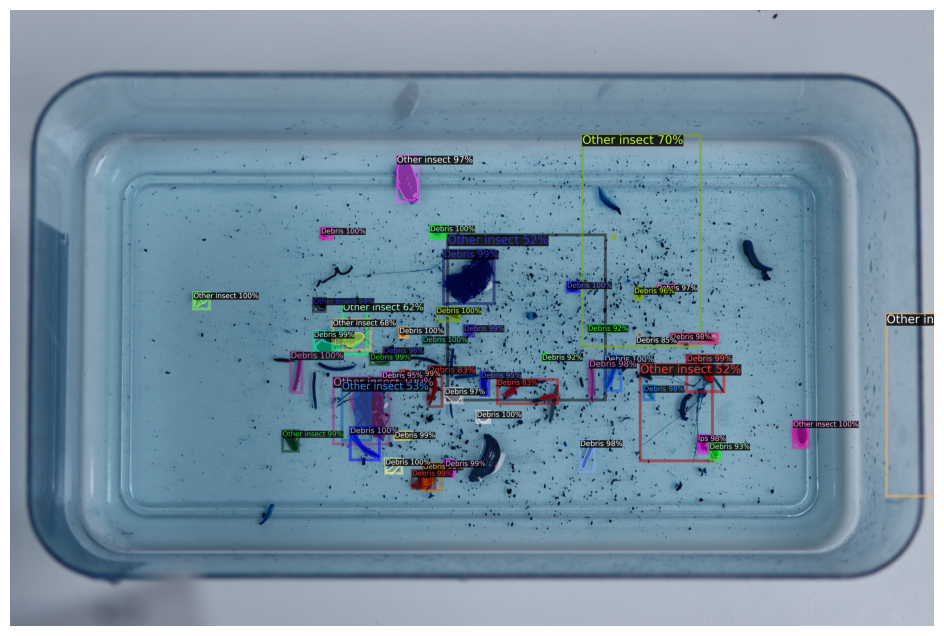

In [ ]:
import cv2
import random
import os
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Correct image folder path
image_folder_path = "/content/drive/MyDrive/BarkBeetle/bark_beetle_detection/images/"
predictions_folder_path = "/content/drive/MyDrive/BarkBeetle/bark_beetle_detection/predictions/"

# Create predictions folder if it doesn't exist
os.makedirs(predictions_folder_path, exist_ok=True)

# List images in the folder to ensure it contains the expected files
print("Listing images in the folder:")
image_files = os.listdir(image_folder_path)  # List images in the folder
print(image_files)

# Load a random image from the directory
#sample_image_path = os.path.join(image_folder_path, random.choice(image_files))  # Choose a random image
sample_image_path = os.path.join(image_folder_path, ('IMG_0068.JPG'))
image = cv2.imread(sample_image_path)

# Check if the image was loaded correctly
if image is None:
    print("Error loading the image.")
else:
    print(f"Loaded image: {sample_image_path}")  # Print loaded image path

    # Make predictions
    outputs = predictor(image)

    # Check predictions
    print("Predictions:", outputs)  # Inspect the outputs
    if outputs["instances"].has("pred_classes"):
        print("Number of instances predicted:", len(outputs["instances"]))
    else:
        print("No instances predicted.")

    # Visualize the predictions
    metadata = MetadataCatalog.get("bark_beetle_val")
    v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.0)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create a new filename with '_prediction' suffix
    base_filename = os.path.basename(sample_image_path)  # Get original filename
    new_filename = os.path.splitext(base_filename)[0] + "_prediction.jpg"  # Append '_prediction' to the name
    saved_image_path = os.path.join(predictions_folder_path, new_filename)  # Create new file path

    # Save the visualized image with predictions
    cv2.imwrite(saved_image_path, v.get_image()[:, :, ::-1])  # Save the image in BGR format

    print(f"Saved image with predictions to: {saved_image_path}")

    # Create directories for each predicted class
    instances = outputs["instances"].to("cpu")
    classes = instances.pred_classes.numpy()  # Get predicted classes
    boxes = instances.pred_boxes.tensor.numpy()  # Get bounding boxes

    # Get the unique classes
    unique_classes = set(classes)
    class_folders = {}

    # Create a folder for each class
    for cls in unique_classes:
        class_name = metadata.thing_classes[cls]  # Get class name
        class_folder_path = os.path.join(predictions_folder_path, class_name)
        os.makedirs(class_folder_path, exist_ok=True)
        class_folders[class_name] = class_folder_path  # Store the class folder path

    # Extract and save each prediction
    for i in range(len(classes)):
        class_name = metadata.thing_classes[classes[i]]
        box = boxes[i].astype(int)  # Convert to integer for indexing

        # Extract the bounding box
        x1, y1, x2, y2 = box
        extracted_image = image[y1:y2, x1:x2]

        # Create a unique filename for each extracted object
        extracted_filename = os.path.join(class_folders[class_name], f"{base_filename}_class_{class_name}_{i}.jpg")
        cv2.imwrite(extracted_filename, extracted_image)  # Save the extracted image

        print(f"Saved extracted image to: {extracted_filename}")

    # Show the image with predictions using matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(v.get_image()[:, :, ::-1])  # Convert BGR to RGB
    plt.axis('off')  # Hide axes
    plt.show()


Class Names: ['Ips', 'Non-Ips beetle', 'Other insect', 'Debris', 'Trap pot contents']
